In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

2023-03-10 16:05:29.687664: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
##GPU 사용 시
device = torch.device("cuda:0")
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /home/mglee/VSCODE/git_folder/KakaoPay_ESG/code/news/.cache/kobert_v1.zip
using cached model. /home/mglee/VSCODE/git_folder/KakaoPay_ESG/code/news/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [9]:
import pandas as pd
comments_unseen = pd.read_csv('/home/mglee/VSCODE/git_folder/comments_sentiment_label/data/KP_comments.tsv', sep = "\t")

In [10]:
comments_unseen

,네이버 페이보다 수수료 낮을까?,0,대조 페이보다 수수료 낮을까?
0,공부해야할 과목이 또 하나 늘었군.. - IT종사자 -,0,공부해야할 과목이 또 하나 늘었군.. - IT종사자 -
1,"네이버도 정기결제, 포인트 적립 다 똑같이 되고 먼저 됐는데요.",0,"대조도 정기결제, 포인트 적립 다 똑같이 되고 먼저 됐는데요."
2,"네이버페이 좋아요.네이버페이체크카드로 교통카드 사용하면 포인트주고, 천원써도 포인...",0,"대조페이 좋아요.대조페이체크카드로 교통카드 사용하면 포인트주고, 천원써도 포인트 ..."
3,네이버페이는 편할거라 생각해서 썼는데 포인트도 제한 교통적립 되긴되는건가?카카오페이...,0,대조페이는 편할거라 생각해서 썼는데 포인트도 제한 교통적립 되긴되는건가?타겟는 막상...
4,카카오페이는 전기세같은거 청구서 카톡으로 받고 한번에 결재할수있어서 좋긴하던데 네이...,0,타겟는 전기세같은거 청구서 카톡으로 받고 한번에 결재할수있어서 좋긴하던데 대조페이는...
...,...,...,...
411983,네이버가 짱이지 ㅋㅋ 올개 30만원 모임 얌얌,0,대조가 짱이지 ㅋㅋ 올개 30만원 모임 얌얌
411984,손절한 주식은???!!!,0,손절한 주식은???!!!
411985,배당금이나 주라,0,배당금이나 주라
411986,어제 새벽부터 카카오페이 안된다!아직도 안되는 이유가 뭐냐?,0,어제 새벽부터 타겟 안된다!아직도 안되는 이유가 뭐냐?


In [11]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
 
    def __len__(self):
        return (len(self.labels))


In [12]:
## Setting parameters
max_len = 64
batch_size = 32
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 500
learning_rate =  5e-5

In [13]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [14]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [19]:
dataset_unseen = nlp.data.TSVDataset("/home/mglee/VSCODE/git_folder/comments_sentiment_label/data/KP_comments.tsv", field_indices=[2,1], num_discard_samples=1)

In [20]:
bertmodel, vocab = get_pytorch_kobert_model()
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /home/mglee/VSCODE/git_folder/KakaoPay_ESG/code/news/.cache/kobert_v1.zip
using cached model. /home/mglee/VSCODE/git_folder/KakaoPay_ESG/code/news/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /home/mglee/VSCODE/git_folder/KakaoPay_ESG/code/news/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [21]:
data_unseen = BERTDataset(dataset_unseen, 0, 1, tok, max_len, True, False)
unseen_dataloader = torch.utils.data.DataLoader(data_unseen, batch_size=batch_size, num_workers=5)

In [22]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()


t_total = len(unseen_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [24]:
model.load_state_dict(torch.load('/home/mglee/VSCODE/git_folder/comments_sentiment_label/result/model/ourB_e5_0307.pt'))
model.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [25]:
out_lst = []

for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(unseen_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    out_lst.append(out.data.cpu())
    max_vals, max_indices = torch.max(out, 1)
    
pred = []
for batch in out_lst:
    for item in batch:
        pred.append(np.argmax(item.numpy()))
        
comments_unseen['pred'] = pred
print("POS/NEG ratio : ", comments_unseen.groupby('pred').size())

100%|██████████| 12875/12875 [04:44<00:00, 45.26it/s]


size :  pred
0    381687
1     30301
dtype: int64


In [26]:
comments_unseen

,네이버 페이보다 수수료 낮을까?,0,대조 페이보다 수수료 낮을까?,pred
0,공부해야할 과목이 또 하나 늘었군.. - IT종사자 -,0,공부해야할 과목이 또 하나 늘었군.. - IT종사자 -,1
1,"네이버도 정기결제, 포인트 적립 다 똑같이 되고 먼저 됐는데요.",0,"대조도 정기결제, 포인트 적립 다 똑같이 되고 먼저 됐는데요.",0
2,"네이버페이 좋아요.네이버페이체크카드로 교통카드 사용하면 포인트주고, 천원써도 포인...",0,"대조페이 좋아요.대조페이체크카드로 교통카드 사용하면 포인트주고, 천원써도 포인트 ...",1
3,네이버페이는 편할거라 생각해서 썼는데 포인트도 제한 교통적립 되긴되는건가?카카오페이...,0,대조페이는 편할거라 생각해서 썼는데 포인트도 제한 교통적립 되긴되는건가?타겟는 막상...,0
4,카카오페이는 전기세같은거 청구서 카톡으로 받고 한번에 결재할수있어서 좋긴하던데 네이...,0,타겟는 전기세같은거 청구서 카톡으로 받고 한번에 결재할수있어서 좋긴하던데 대조페이는...,0
...,...,...,...,...
411983,네이버가 짱이지 ㅋㅋ 올개 30만원 모임 얌얌,0,대조가 짱이지 ㅋㅋ 올개 30만원 모임 얌얌,0
411984,손절한 주식은???!!!,0,손절한 주식은???!!!,0
411985,배당금이나 주라,0,배당금이나 주라,0
411986,어제 새벽부터 카카오페이 안된다!아직도 안되는 이유가 뭐냐?,0,어제 새벽부터 타겟 안된다!아직도 안되는 이유가 뭐냐?,0


In [27]:
comments = pd.read_csv("/home/mglee/VSCODE/git_folder/KakaoPay_ESG/data/news_comments_date.csv")

In [36]:
comments = comments.drop(0)

In [38]:
comments['pred'] = pred

In [53]:
ymd_senti = comments.groupby('ymd')['pred'].mean()

In [67]:
ymd_senti[1693:]

ymd
2022-01-01    0.080292
2022-01-02    0.049587
2022-01-03    0.052632
2022-01-04    0.042138
2022-01-05    0.044628
                ...   
2023-01-09    0.000000
2023-01-10    0.000000
2023-01-12    0.000000
2023-01-14    0.000000
2023-01-15    0.000000
Name: pred, Length: 378, dtype: float64

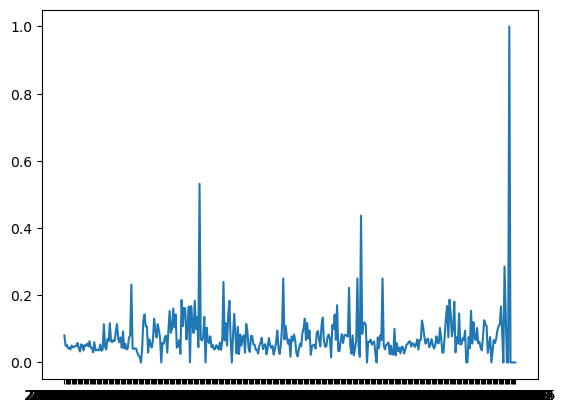

In [68]:
import matplotlib.pyplot as plt
plt.plot(ymd_senti[1693:])